In [1]:
import math
import random
import csv
from collections import Counter, defaultdict
from typing import List, NamedTuple, Dict, Tuple
import requests
from matplotlib import pyplot as plt

In [2]:
def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner
# assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'

def majority_vote(labels: List[str]) -> str:
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])
    if num_winners == 1:
        return winner
    else:
        return majority_vote(labels[:-1])

# assert majority_vote(['a','b', 'c', 'b', 'a']) == 'b'

In [3]:
# Linear algebra components
Vector = List[float]

def distance(v1: Vector, v2: Vector) -> float:
    """Computes the Euclidean distance between two vectors"""
    return math.sqrt(sum((v1_i - v2_i) ** 2 for v1_i, v2_i in zip(v1, v2)))

# LabeledPoint class
class LabeledPoint(NamedTuple):
    point: Vector
    label: str

# k-NN classifier
def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:
    """
    Classify a new point using k-nearest neighbors.
    Args:
        k: Number of nearest neighbors to consider
        labeled_points: Training data points with labels.
        new_point: Point to classify
    Returns:
        Predicted label for the new point
    """
    # Order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))
    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    # and let them vote
    return majority_vote(k_nearest_labels)

In [4]:
# Download the Iris dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
response = requests.get(url)
with open('iris.dat', 'w') as f:
    f.write(response.text)


In [5]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    Parses a single row from the Iris dataset CSV.
    Args:
        row: A list of strings representing a row in the CSV.
    Returns:
        A LabeledPoint containing the measurements and label,
        or None if the row is invalid.
    """
    # Check if the row has the expected number of columns (usually 5 for Iris)
    if len(row) != 5:
        return None  # Skip invalid rows
    try:
        measurements = [float(value) for value in row[:-1]]
        label = row[-1].split("-")[-1]
        return LabeledPoint(measurements, label)
    except ValueError:
        return None  # Skip rows with non-float measurement values

with open('iris.dat') as f:
    reader = csv.reader(f)
    # Filter out None values returned for invalid rows
    iris_data = [parse_iris_row(row) for row in reader if parse_iris_row(row) is not None]

points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

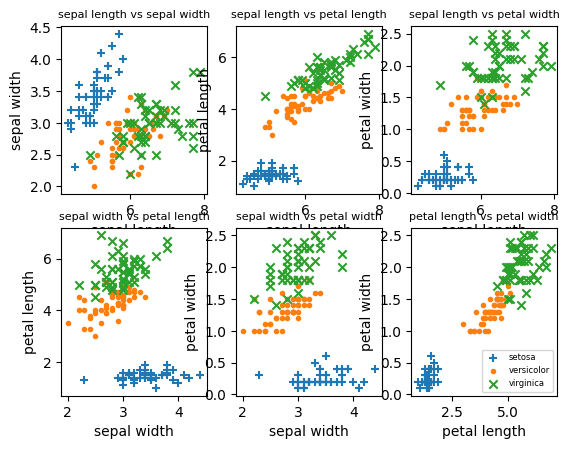

Accuracy: 0.9777777777777777
Confusion Matrix:
defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


In [ ]:
# Plotting the data
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']  # we have 3 classes, so 3 markers
fig, ax = plt.subplots(2, 3)
for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row, col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row, col].set_xlabel(metrics[i])
        ax[row, col].set_ylabel(metrics[j])
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

# A function to split data (assuming this was defined elsewhere)
def split_data(data: List, prob: float) -> Tuple[List, List]:
    """Splits data into two parts with a given probability."""
    data = data[:]  # Make a shallow copy
    random.shuffle(data)
    cut = int(len(data) * prob)
    return data[:cut], data[cut:]


# split the data into a test set and a training set:
random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
assert len(iris_train) + len(iris_test) == len(iris_data)

# Evaluate the model
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0
for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    if predicted == actual:
        num_correct += 1
    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(f"Accuracy: {pct_correct}")
print("Confusion Matrix:")
print(confusion_matrix)